In [59]:
import importlib
from volo_tools import volo_data
import numpy as np
import pandas as pd
from volo_tools import volo_feature_impl 
importlib.reload(volo_data)
importlib.reload(volo_feature_impl)
processor = volo_data.VoloDataProcessor()
processor.process("beta_project_data.csv")
print(processor.data.head())

Stocks with adjustment factor changes:
Symbol
AAPL      1510
CELG      1127
CMCS.A    1510
CRM        827
EOG       1067
GILD       771
GOOG       272
ICE       1510
KR        1390
LBTY.K    1047
MA        1019
NFLX      1391
NKE       1500
SBUX      1324
TSLA      1388
UAA       1077
UNP       1114
V         1310
dtype: int64
         Code Symbol       Date  Close      Volume  Adjustment Factor  \
275483  59268   AABA 2010-01-04  17.10  16600000.0                1.0   
93289   59268   AABA 2010-01-05  17.23  11700000.0                1.0   
29827   59268   AABA 2010-01-06  17.17  16400000.0                1.0   
275009  59268   AABA 2010-01-07  16.70  31800000.0                1.0   
103111  59268   AABA 2010-01-08  16.70  15500000.0                1.0   

        Adj_Close  
275483      17.10  
93289       17.23  
29827       17.17  
275009      16.70  
103111      16.70  


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

data_dir = "data"
graph_dir = os.path.join(data_dir, "graphs")
os.makedirs(graph_dir, exist_ok=True)

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

all_betas = {}
symbol_std_list = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        if "Beta_45d" in df.columns:
            symbol = os.path.basename(file).replace("_data.csv", "")
            df = df.dropna(subset=["Beta_45d"])
            if len(df) == 0:
                continue

            all_betas[symbol] = df["Beta_45d"].values
            beta_std = df["Beta_45d"].std(skipna=True)
            symbol_std_list.append({"Symbol": symbol, "Beta_45d_STD": beta_std})
    except Exception as e:
        print(f"Error reading {file}: {e}")

In [ ]:
importlib.reload(volo_feature_impl)
from sklearn.metrics import mean_squared_error, r2_score

train_window = 500
steps = 30
smoothing_window = 5

spy_data = pd.read_csv('data/SPY_data.csv')
spy_data.set_index("Date", inplace=True)
feature_processor = volo_feature_impl.VoloFeatureImpl()
spy, har_model = feature_processor._prepare_spy_baseline(spy_data, future_window=45)
spy.dropna(inplace=True)
spy["target_multiplier"] = spy["RV_future"]/spy["HAR_Pred"]
# Exponential smoothing of the target multiplier
spy["smoothed_multiplier"] = spy["target_multiplier"].ewm(span=smoothing_window, adjust=False).mean()

spy.to_csv('spy_target_sanity_check.csv')

#
avg_abs_diff = np.mean(np.abs(spy["RV_future"] - spy["HAR_Pred"]))
print(avg_abs_diff)
har_mse = mean_squared_error(spy["RV_future"], spy["HAR_Pred"])
har_r2 = r2_score(spy["RV_future"], spy["HAR_Pred"])
print(har_mse)
print(har_r2)

             Code Symbol   Close       Volume  Adjustment Factor  Adj_Close  \
Date                                                                          
2010-01-05  59751    SPY  113.63  112000000.0                1.0     113.63   
2010-01-06  59751    SPY  113.71  116000000.0                1.0     113.71   
2010-01-07  59751    SPY  114.19  131000000.0                1.0     114.19   
2010-01-08  59751    SPY  114.57  126000000.0                1.0     114.57   
2010-01-11  59751    SPY  114.73  106000000.0                1.0     114.73   

            Log_Return  SPY_Return  Beta_45d  Future_Beta_45d  Variance_45d  \
Date                                                                          
2010-01-05    0.002644    0.002644       NaN              1.0           NaN   
2010-01-06    0.000704    0.000704       NaN              1.0           NaN   
2010-01-07    0.004212    0.004212       NaN              1.0           NaN   
2010-01-08    0.003322    0.003322       NaN       

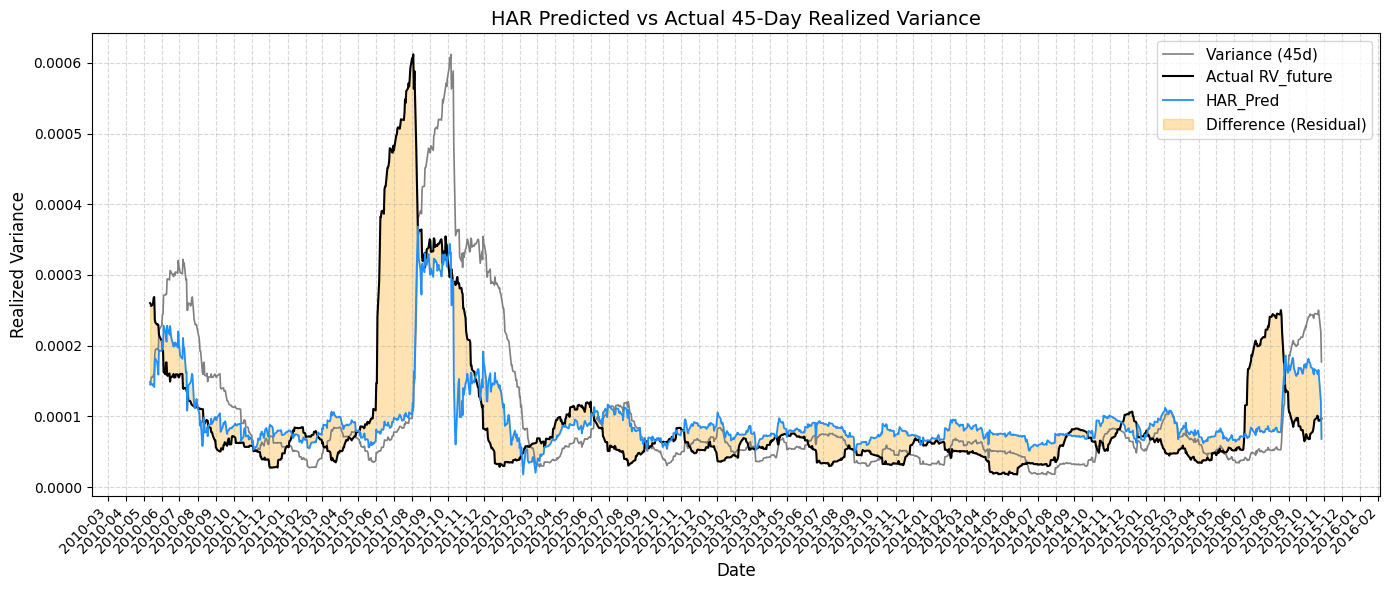

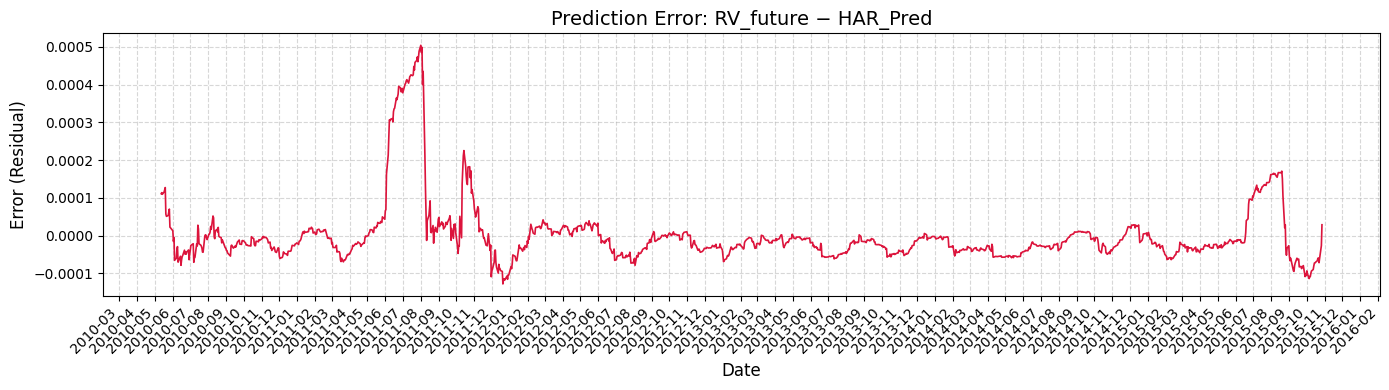

In [76]:
import matplotlib.dates as mdates
# Ensure index is datetime
if spy.index.dtype == "object" or not np.issubdtype(spy.index.dtype, np.datetime64):
    spy.index = pd.to_datetime(spy.index, errors="coerce")

spy = spy[~spy.index.isna()].sort_index()

# -----------------------------------
# Plot HAR vs RV_future and difference
# -----------------------------------
plt.figure(figsize=(14, 6))

if "Variance_45d" in spy.columns:
    plt.plot(spy.index, spy["Variance_45d"], label="Variance (45d)", color="gray", linewidth=1.2)

plt.plot(spy.index, spy["RV_future"], label="Actual RV_future", color="black", linewidth=1.5)
plt.plot(spy.index, spy["HAR_Pred"], label="HAR_Pred", color="dodgerblue", linewidth=1.3)

plt.fill_between(
    spy.index, spy["RV_future"], spy["HAR_Pred"],
    color="orange", alpha=0.3, label="Difference (Residual)"
)

plt.title("HAR Predicted vs Actual 45-Day Realized Variance", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Realized Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
# Use month ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

# -----------------------------------
# Residual plot
# -----------------------------------
plt.figure(figsize=(14, 4))
plt.plot(spy.index, spy["RV_future"] - spy["HAR_Pred"], color="crimson", linewidth=1.2)

plt.title("Prediction Error: RV_future − HAR_Pred", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Error (Residual)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [62]:
import os
import glob
import pandas as pd
from sklearn.decomposition import FastICA
import numpy as np

def feature_collector(all_symbols, spy_path="data/SPY_data.csv"):
    """
    Collects and merges features for a list of symbols.
    """
    if not os.path.exists(spy_path):
        raise FileNotFoundError(f"SPY data not found at {spy_path}")
    
    data = spy

    for symbol in all_symbols:
        file_path = f"data/{symbol}_data.csv"
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping.")
            continue

        symbol_data = pd.read_csv(file_path)
        
        data = pd.merge(
            data,
            symbol_data,
            on="Date",
            how="outer",
            suffixes=("", f"_{symbol}")
        )

    data.sort_values("Date", inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Remove columns not needed for analysis
    data = data.loc[:, ~data.columns.str.contains('Future_Beta_45d')]
    data = data.loc[:, ~data.columns.str.contains('Code')]
    data = data.loc[:, ~data.columns.str.contains('RV_future')]
    data = data.loc[:, ~data.columns.str.contains('Symbol')]
    data = data.loc[:, ~data.columns.str.contains('Residual')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
        
    return data

# --- Main execution block ---

data_dir = "data/"
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_variance = feature_collector(valid_symbols, spy_path="data/SPY_data.csv")

bond_etfs = [ "BND", "AGG", "TLT", "SHY" ]
etf_list = [
    "DIA", "IJH", "IBB", "IVV", "IWB", "IWD", "IWF", "IWM", "IWN", "IWR",
    "IYR", "MDY", "NFLX", "QQQ", "SPY", "V", "VLO", "VNQ", "VOO", "VTI",
    "VTV", "XOP"
]

# --- Corrected Universe-Based Rolling ICA Implementation ---

# 1. PRECISELY identify ONLY the 'Adj Close' columns for the ETF universe.
etf_set = set(etf_list) # Use a set for fast lookups
ica_input_cols = []
for col in x_variance.columns:
    # Handle suffixed columns like 'Adj Close_AGG'
    if col.startswith('Adj_Close_') and col.split('_')[-1] in etf_set:
        ica_input_cols.append(col)
    # Handle the base case for SPY, which is just 'Adj Close'
    elif col == 'Adj_Close' and 'SPY' in etf_set:
        ica_input_cols.append(col)

if not ica_input_cols:
    print("No 'Adj Close' columns for the specified ETFs were found. Exiting ICA process.")
    x_variance_final = x_variance.copy()
else:
    print(f"Found {len(ica_input_cols)} 'Adj Close' columns to use for ICA.")
    
    # 2. Define parameters and select the data for ICA
    window_size = 45
    n_components = 10 
    
    etf_data_for_ica = x_variance[ica_input_cols]
    
    # 3. Perform rolling ICA on the selected 'Adj Close' data
    ica_components_array = np.full((len(etf_data_for_ica), n_components), np.nan)
    ica = FastICA(n_components=n_components, random_state=0, max_iter=10000, tol=0.1)
    
    print(f"Processing rolling ICA...")
    for i in range(window_size, len(etf_data_for_ica) + 1):
        window = etf_data_for_ica.iloc[i - window_size:i].values
        try:
            transformed_window = ica.fit_transform(window)
            ica_components_array[i - 1] = transformed_window[-1, :]
        except Exception:
            pass

    # 4. Create a DataFrame with the new ICA component features
    ica_component_names = [f"ICA_ETF_Universe_component_{i}" for i in range(n_components)]
    ica_results_df = pd.DataFrame(ica_components_array, index=x_variance.index, columns=ica_component_names)
    
    # 5. Combine the original data with the new ICA features
    x_variance_with_ica = pd.concat([x_variance, ica_results_df], axis=1)

    # 6. CRITICAL STEP: Drop ONLY the 'Adj Close' columns that were used as input for the ICA
    print(f"Removing the {len(ica_input_cols)} 'Adj Close' columns used as ICA input.")
    x_variance_final = x_variance_with_ica.drop(columns=ica_input_cols)

    # Drop rows with NaN values created by the rolling window
    x_variance_final.dropna(inplace=True)
    x_variance = x_variance_final.copy()
    

# --- Final Output ---
print("\nDataFrame head after adding ICA components and removing ONLY the source 'Adj Close' columns:")
print(x_variance_final.head())
print(f"\nFinal DataFrame contains {x_variance_final.shape[1]} columns.")


# Ensure the results directory exists
if not os.path.exists("results"):
    os.makedirs("results")
    
x_variance_final.to_csv("results/combined_features_with_adj_close_ica.csv", index=False)

Found 23 'Adj Close' columns to use for ICA.
Processing rolling ICA...
Removing the 23 'Adj Close' columns used as ICA input.

DataFrame head after adding ICA components and removing ONLY the source 'Adj Close' columns:
          Date   Close       Volume  Adjustment Factor  Log_Return  \
44  2011-03-21  129.74  154000000.0                1.0    0.015379   
45  2011-03-22  129.29  130000000.0                1.0   -0.003475   
46  2011-03-23  129.66  149000000.0                1.0    0.002858   
47  2011-03-24  130.90  159000000.0                1.0    0.009518   
48  2011-03-25  131.30  156000000.0                1.0    0.003051   

    SPY_Return  Beta_45d  Variance_45d  Variance_45d_MA  Variance_5d_MA  ...  \
44    0.015379       1.0      0.000085         0.000046        0.000078  ...   
45   -0.003475       1.0      0.000084         0.000047        0.000081  ...   
46    0.002858       1.0      0.000084         0.000048        0.000082  ...   
47    0.009518       1.0      0.000083 

In [63]:
import xgboost as xgb
def rolling_xgb(df, target_col="target_multiplier", train_window=500, step=5):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")
    # Define features (exclude date and target)
    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    # remove any non-numeric columns from x_cols except date
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]
    preds, actuals, dates = [], [], []
    all_feature_importance = []

    # Check for GPU availability safely
    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for start in range(train_window, len(df) - step, step):
        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        # Safety: ensure no target col accidentally left in features
        X_train = X_train.drop(columns=["target_multiplier"], errors="ignore")
        X_test = X_test.drop(columns=["target_multiplier"], errors="ignore")

        # Model parameters
        params = dict(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

        # GPU acceleration if supported
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )

        # -----------------------------------------
        # Record feature importances for this window
        # -----------------------------------------
        imp = model.get_booster().get_score(importance_type="gain")
        imp_df = pd.DataFrame(list(imp.items()), columns=["Feature", "Gain"])
        imp_df["Window_Start"] = start
        all_feature_importance.append(imp_df)

        print(f"\nTop Features for window starting at {start}:")
        print(imp_df.sort_values("Gain", ascending=False).head(5).to_string(index=False))

        # Predict
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)

    # Combine results
    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds
    }).sort_values("Date")
    result_df.set_index("Date", inplace=True)

    # -----------------------------------------
    # Aggregate global feature importances
    # -----------------------------------------
    if all_feature_importance:
        all_imp_df = pd.concat(all_feature_importance, ignore_index=True)
        all_imp_df.to_csv("results/feature_importances_SPY.csv", index=False, float_format="%.6f")
        global_imp = (
            all_imp_df.groupby("Feature")["Gain"]
            .mean()
            .sort_values(ascending=False)
            .reset_index()
        )
        print("\n=== Global Average Feature Importance (Gain) ===")
        print(global_imp.to_string(index=False))

    return result_df


# ============================================================
# Example usage
# ============================================================
pred_df_spy_var = rolling_xgb(x_variance)
print(pred_df_spy_var.head())
backup_spy_var = pred_df_spy_var.copy()

c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 500:
              Feature       Gain  Window_Start
  Variance_45d_MA_MET 282.141968           500
  Variance_45d_MA_VXX 125.138596           500
  Variance_45d_MA_WMT  92.607254           500
  Variance_45d_MA_IWB  26.534363           500
Variance_45d_MA_BRK.B  22.288464           500


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 505:
              Feature       Gain  Window_Start
  Variance_45d_MA_MET 293.453369           505
  Variance_45d_MA_VXX 146.031418           505
  Variance_45d_MA_IWB  24.907700           505
Variance_45d_MA_BRK.B  18.575678           505
  Variance_45d_MA_WMT  17.539040           505


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 510:
              Feature       Gain  Window_Start
  Variance_45d_MA_VXX 114.721512           510
 Variance_45d_MA_REGN  48.030834           510
  Variance_45d_MA_WMT  26.135386           510
Variance_45d_MA_BRK.B  15.867200           510
    Variance_5d_MA_KO  14.654466           510


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 515:
            Feature       Gain  Window_Start
Variance_45d_MA_MET 271.152466           515
Variance_45d_MA_VXX 104.689926           515
Variance_45d_MA_WMT  28.303577           515
Variance_5d_MA_ORCL  14.572162           515
       Beta_45d_IWB  11.014141           515


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 520:
             Feature       Gain  Window_Start
Variance_45d_MA_AAPL 281.239319           520
 Variance_45d_MA_VXX 101.503319           520
 Variance_45d_MA_WMT  25.986050           520
        Beta_45d_XLI  15.418219           520
 Variance_45d_MA_AGN  13.147470           520


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 525:
              Feature       Gain  Window_Start
  Variance_45d_MA_MET 285.454468           525
  Variance_45d_MA_VXX 117.520935           525
  Variance_45d_MA_WMT  25.228739           525
  Variance_45d_MA_SPY  22.886993           525
Variance_45d_MA_BRK.B  15.556949           525


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 530:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 129.067871           530
Variance_45d_MA_MET 110.371185           530
Variance_45d_MA_WMT  27.393122           530
Variance_45d_MA_IWB  25.262859           530
    Variance_45d_KO  19.735004           530


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 535:
             Feature       Gain  Window_Start
 Variance_45d_MA_VXX 117.064171           535
Variance_45d_MA_REGN  58.894501           535
 Variance_45d_MA_WMT  23.202065           535
  Variance_5d_MA_ICE  15.953766           535
 Variance_45d_MA_IWB  12.970592           535


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 540:
             Feature       Gain  Window_Start
 Variance_45d_MA_MET 287.485168           540
 Variance_45d_MA_VXX 131.494034           540
        Beta_45d_KMB  24.309902           540
 Variance_45d_MA_WMT  24.183855           540
Variance_45d_MA_UPRO  17.756716           540


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 545:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 146.804153           545
Variance_45d_MA_MET 142.540863           545
Variance_45d_MA_WMT  46.904625           545
          Close_VWO  31.139423           545
     Adj_Close_BIDU  16.130077           545


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 550:
             Feature       Gain  Window_Start
           Close_IEF 194.921524           550
Variance_45d_MA_REGN 113.405640           550
       Adj_Close_IEF  73.793938           550
           Close_TLT  63.440868           550
 Variance_45d_MA_VXX  34.208168           550


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 555:
            Feature       Gain  Window_Start
          Close_TLT 457.004364           555
 Variance_45d_MA_GS 262.309662           555
      Adj_Close_TLT 170.607651           555
Variance_5d_MA_NFLX  78.293121           555
Variance_45d_MA_VXX  63.309956           555


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 560:
            Feature       Gain  Window_Start
Variance_5d_MA_NFLX 131.541489           560
Variance_45d_MA_VXX 102.941727           560
      Adj_Close_TLT  57.497501           560
          Close_EEM  36.397526           560
Variance_45d_MA_IVV  13.667204           560


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 565:
            Feature       Gain  Window_Start
          Close_HAL 213.038422           565
Variance_5d_MA_NFLX 181.356354           565
          Close_TLT 122.055412           565
  Variance_45d_MA_C  41.212299           565
Variance_45d_MA_VXX  33.407070           565


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 570:
            Feature       Gain  Window_Start
Variance_5d_MA_NFLX 109.564537           570
Variance_45d_MA_VXX  89.293098           570
Variance_45d_MA_WMT  41.843948           570
       Beta_45d_BAC  12.633690           570
       Beta_45d_FDX   9.504548           570


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 575:
              Feature       Gain  Window_Start
  Variance_45d_MA_VXX 109.476387           575
  Variance_5d_MA_NFLX  60.340588           575
            Close_TLT  41.661388           575
 Variance_45d_MA_ALXN  25.277529           575
Variance_45d_MA_BRK.B  14.888247           575


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 580:
             Feature      Gain  Window_Start
 Variance_45d_MA_VXX 38.431709           580
Variance_45d_MA_NFLX 35.427280           580
Variance_45d_MA_AAPL 31.527481           580
           Close_TLT 20.122919           580
     Beta_45d_LBTY.A 15.584475           580


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 585:
              Feature      Gain  Window_Start
  Variance_5d_MA_NFLX 40.278126           585
      Beta_45d_GOOG.L 24.880133           585
Variance_45d_MA_BRK.B 21.638273           585
    Variance_45d_ILMN 17.916983           585
      Beta_45d_CMCS.A 17.284229           585


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 590:
            Feature      Gain  Window_Start
Variance_45d_MA_MDT 25.304718           590
Variance_5d_MA_ORCL 13.129683           590
Variance_45d_MA_IWB 11.881414           590
       Beta_45d_KMB 11.647346           590
          Close_NKE  9.238169           590


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 595:
            Feature      Gain  Window_Start
       Beta_45d_KMB 11.398956           595
Variance_5d_MA_ORCL 11.093901           595
Variance_45d_MA_CAT  9.495358           595
       Beta_45d_SLB  6.995917           595
          Close_NKE  6.868465           595


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 600:
            Feature      Gain  Window_Start
        MA_45d_ALXN 14.850846           600
Variance_5d_MA_ILMN 13.102566           600
Variance_5d_MA_ORCL 12.564137           600
       Beta_45d_KMB 11.747642           600
       Beta_45d_SLB  6.437538           600


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 605:
            Feature      Gain  Window_Start
       MA_5d_LBTY.K 15.826811           605
Variance_45d_MA_IWB 13.008815           605
          Close_NKE 10.995932           605
   Variance_45d_DXJ  9.426342           605
       Beta_45d_KMB  9.330631           605


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 610:
              Feature      Gain  Window_Start
Variance_45d_MA_BRK.B 23.694483           610
            Close_NKE 14.444760           610
         Beta_45d_KMB 12.197915           610
         Beta_45d_XOM 10.704771           610
  Variance_5d_MA_ORCL 10.247280           610


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 615:
              Feature      Gain  Window_Start
Variance_45d_MA_BRK.B 28.273241           615
          MA_45d_ALXN 10.497352           615
         Beta_45d_BAC  9.984709           615
         Beta_45d_KMB  8.511018           615
  Variance_5d_MA_REGN  7.862506           615


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 620:
              Feature      Gain  Window_Start
Variance_45d_MA_BRK.B 13.624002           620
  Variance_45d_MA_IWB 10.235375           620
  Variance_5d_MA_CELG 10.053701           620
         Beta_45d_KMB  7.960577           620
            Close_PEP  6.445149           620


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 625:
            Feature      Gain  Window_Start
          Close_PEP 11.763958           625
Variance_45d_MA_VTI 10.632380           625
       Beta_45d_KMB  9.240865           625
   Variance_45d_DUK  7.100912           625
         MA_5d_AAPL  7.069178           625


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 630:
            Feature      Gain  Window_Start
          Close_PEP 16.415575           630
       Beta_45d_XOM 10.499101           630
   Variance_45d_DUK  7.347350           630
          MA_5d_COP  6.379025           630
Variance_5d_MA_ORCL  5.586070           630


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 635:
           Feature     Gain  Window_Start
      Beta_45d_KMB 7.351026           635
      Beta_45d_DUK 6.742606           635
Variance_5d_MA_DUK 4.897229           635
Variance_5d_MA_WMB 4.666973           635
         Close_PEP 3.738597           635


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 640:
           Feature     Gain  Window_Start
      Beta_45d_BAC 7.742137           640
      Beta_45d_KMB 5.924672           640
     Adj_Close_OXY 4.556828           640
        Close_AMLP 4.075447           640
Variance_5d_MA_DUK 3.798988           640


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 645:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 14.355965           645
         MA_45d_EWZ  7.104713           645
         MA_45d_TXN  5.934547           645
      Beta_45d_SBUX  4.393950           645
  Variance_45d_CELG  3.227231           645


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 650:
            Feature     Gain  Window_Start
Variance_5d_MA_CELG 9.403325           650
          Close_NKE 6.887695           650
         MA_45d_XLB 5.585943           650
 Variance_5d_MA_EPD 2.476369           650
   Variance_45d_DXJ 1.928672           650


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 655:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 13.845790           655
  Variance_45d_CELG  8.105847           655
          Close_NKE  5.018830           655
         Close_REGN  4.308137           655
         MA_45d_EPD  2.555786           655


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 660:
            Feature     Gain  Window_Start
Variance_5d_MA_CELG 9.857465           660
  Variance_45d_CELG 9.377796           660
          Close_NKE 4.763954           660
        Beta_45d_MO 4.135585           660
 Variance_5d_MA_DUK 2.939937           660


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 665:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 12.940387           665
          Close_NKE  5.780156           665
   Variance_45d_DXJ  5.701418           665
 Variance_5d_MA_EPD  3.292500           665
         MA_45d_OXY  2.492543           665


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 670:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 12.517525           670
          MA_45d_BP  5.212937           670
          Close_NKE  4.801450           670
 Variance_5d_MA_EPD  2.900630           670
      Beta_45d_SBUX  2.696658           670


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 675:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 15.459850           675
          Close_NKE  8.600844           675
 Variance_5d_MA_EPD  3.509336           675
   Variance_45d_DXJ  3.287403           675
         Close_AMLP  2.607539           675


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 680:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 16.345659           680
         MA_45d_XLI  6.084174           680
          Close_NKE  5.173630           680
   Variance_45d_DXJ  4.048693           680
Variance_45d_MA_MDT  3.782731           680


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 685:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 16.724819           685
  Variance_45d_CELG  7.734114           685
Variance_45d_MA_VGK  5.751053           685
   Variance_45d_DXJ  4.129448           685
Variance_5d_MA_AMLP  3.456555           685


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 690:
            Feature      Gain  Window_Start
      Adj_Close_DUK 13.309301           690
          Close_KMB 11.449615           690
Variance_5d_MA_CELG  7.895422           690
      Adj_Close_KMB  6.215810           690
Variance_45d_MA_WFC  5.721430           690


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 695:
            Feature      Gain  Window_Start
      Adj_Close_DUK 14.006347           695
          Close_DUK 11.175782           695
      Adj_Close_KMB  8.974473           695
          Close_WMT  7.535489           695
Variance_45d_MA_WFC  4.914057           695


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 700:
            Feature      Gain  Window_Start
 Variance_45d_MA_BK 10.755174           700
          Close_KMB  9.801672           700
Variance_45d_MA_WFC  4.120413           700
Variance_5d_MA_AMLP  3.876519           700
 Variance_5d_MA_DUK  3.318327           700


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 705:
            Feature     Gain  Window_Start
 Variance_45d_MA_BK 7.297131           705
Variance_45d_MA_WFC 6.795640           705
Variance_5d_MA_CELG 6.504995           705
          Close_WMT 6.047160           705
          Close_KMB 5.820107           705


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 710:
           Feature      Gain  Window_Start
Variance_5d_MA_KMB 13.993951           710
         Close_KMB  7.581413           710
     Adj_Close_DUK  7.319429           710
 Variance_45d_CELG  5.653025           710
      Beta_45d_KMB  3.892008           710


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 715:
            Feature     Gain  Window_Start
  Variance_45d_CELG 5.435581           715
Variance_45d_MA_ABT 3.769025           715
       Beta_45d_VEU 2.866012           715
Variance_45d_MA_ICE 2.389267           715
  Variance_45d_SPXU 2.227701           715


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 720:
           Feature     Gain  Window_Start
 Variance_45d_CELG 3.746127           720
  Variance_45d_LMT 2.773964           720
  Variance_45d_DUK 2.187573           720
Variance_5d_MA_EPD 1.834072           720
  Variance_45d_DIA 1.691376           720


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 725:
            Feature     Gain  Window_Start
 Variance_5d_MA_DIA 4.365690           725
  Variance_45d_CELG 4.185859           725
Variance_45d_MA_ABT 3.332718           725
 Variance_45d_MA_BK 2.523474           725
   Variance_45d_LMT 1.972983           725


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 730:
            Feature     Gain  Window_Start
  Variance_45d_CELG 4.777462           730
Variance_45d_MA_ABT 4.013569           730
   Variance_45d_LMT 2.489393           730
 Variance_5d_MA_DIA 1.981745           730
Variance_45d_MA_ICE 1.791410           730


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 735:
           Feature     Gain  Window_Start
 Variance_45d_CELG 3.376428           735
  Variance_45d_LMT 2.772755           735
Variance_5d_MA_DIA 2.215608           735
  Variance_45d_DIA 1.465518           735
 Variance_45d_AMGN 1.245865           735


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 740:
             Feature     Gain  Window_Start
   Variance_45d_CELG 3.921281           740
Variance_45d_MA_COST 3.101706           740
  Variance_5d_MA_DIA 2.612707           740
        Beta_45d_VEU 2.048051           740
    Variance_45d_LMT 1.819647           740


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 745:
             Feature     Gain  Window_Start
  Variance_5d_MA_DIA 3.477496           745
Variance_45d_MA_COST 3.316749           745
    Variance_45d_LMT 2.219734           745
    Variance_45d_DIA 1.739193           745
   Variance_45d_CELG 1.388857           745


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 750:
           Feature     Gain  Window_Start
  Variance_45d_LMT 2.437296           750
Variance_5d_MA_XLI 2.394204           750
        MA_45d_ICE 2.349043           750
 Variance_45d_CELG 2.222001           750
  Variance_45d_DIA 1.595887           750


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 755:
           Feature     Gain  Window_Start
Variance_5d_MA_DIA 3.580221           755
  Variance_45d_XLV 2.067423           755
  Variance_45d_LMT 2.041882           755
  Variance_45d_DIA 1.856726           755
       Beta_45d_MO 1.805210           755


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 760:
             Feature     Gain  Window_Start
    Variance_45d_LMT 1.889467           760
Variance_45d_MA_SCHW 1.869052           760
          MA_45d_ABT 1.561596           760
    Variance_45d_IBB 1.515896           760
  Variance_5d_MA_UTX 1.342943           760


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 765:
           Feature     Gain  Window_Start
Variance_5d_MA_XLI 4.235259           765
      Beta_45d_HAL 2.177454           765
  Variance_45d_XLV 2.167025           765
  Variance_45d_IBB 1.327468           765
Variance_45d_MA_DD 1.291098           765


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 770:
           Feature     Gain  Window_Start
Variance_5d_MA_IBB 5.531647           770
  Variance_45d_DUK 2.163039           770
  Variance_45d_IBB 1.916036           770
Variance_5d_MA_UTX 1.532830           770
  Variance_45d_XLV 1.515504           770


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 775:
            Feature     Gain  Window_Start
Variance_45d_MA_DOW 4.515641           775
       Beta_45d_SLB 4.040255           775
 Variance_45d_MA_DD 2.575974           775
   Variance_45d_IBB 2.017274           775
   Variance_45d_AMJ 1.210839           775


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 780:
           Feature     Gain  Window_Start
  Variance_45d_XLY 3.296861           780
  Variance_45d_XLV 2.044084           780
Variance_5d_MA_EPD 1.580426           780
  Variance_45d_AMJ 1.315230           780
Variance_5d_MA_PXD 1.250160           780


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 785:
           Feature     Gain  Window_Start
  Variance_45d_XLY 2.889170           785
      Beta_45d_IWD 2.819776           785
Variance_5d_MA_EPD 2.458857           785
Variance_5d_MA_VXX 1.679194           785
Variance_5d_MA_IBB 1.636502           785


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 790:
            Feature     Gain  Window_Start
        MA_45d_ESRX 3.292243           790
   Variance_45d_XLY 2.279455           790
   Variance_45d_IWF 2.189419           790
Variance_45d_MA_UNH 1.576708           790
Variance_45d_MA_AIG 1.557856           790


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 795:
            Feature     Gain  Window_Start
   Variance_45d_XLY 2.736489           795
        MA_45d_ESRX 2.596579           795
Variance_45d_MA_AIG 1.526428           795
Variance_45d_MA_AGN 1.276153           795
   Variance_45d_IWF 1.228367           795


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 800:
           Feature     Gain  Window_Start
Variance_5d_MA_IBB 4.021957           800
  Variance_45d_XLY 2.610703           800
      Beta_45d_IWD 2.241802           800
       MA_45d_ESRX 1.800624           800
 Variance_45d_SPXU 1.722126           800


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 805:
            Feature     Gain  Window_Start
        MA_45d_ESRX 2.839638           805
Variance_45d_MA_AIG 2.235262           805
   Variance_45d_IWF 2.209452           805
   Variance_45d_XLY 2.059412           805
Variance_45d_MA_UNH 1.607322           805


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 810:
            Feature     Gain  Window_Start
   Variance_45d_XLY 3.627733           810
        MA_45d_ESRX 2.496155           810
Variance_5d_MA_AMLP 2.068679           810
       Beta_45d_LMT 1.999472           810
 Variance_5d_MA_VXX 1.704635           810


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 815:
            Feature     Gain  Window_Start
Variance_45d_MA_DOW 3.308170           815
       Beta_45d_SLB 2.360103           815
   Variance_45d_XLY 1.819447           815
        MA_45d_ESRX 1.760345           815
Variance_5d_MA_AMLP 1.281449           815


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 820:
            Feature     Gain  Window_Start
 Variance_45d_MA_DD 2.958486           820
       Beta_45d_SLB 2.837797           820
Variance_45d_MA_DOW 1.598284           820
Variance_5d_MA_AMLP 1.384456           820
      Beta_45d_AMGN 1.036503           820


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 825:
            Feature     Gain  Window_Start
Variance_45d_MA_DOW 2.805676           825
       Beta_45d_SLB 2.666349           825
      Beta_45d_AMGN 1.600668           825
       Beta_45d_JPM 1.175424           825
 Variance_5d_MA_EPD 1.166970           825


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 830:
          Feature     Gain  Window_Start
     Beta_45d_APC 2.566612           830
        MA_45d_HD 1.862320           830
Variance_45d_AABA 1.782191           830
   Beta_45d_BRK.B 1.776194           830
    Beta_45d_AMGN 1.286523           830


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 835:
            Feature     Gain  Window_Start
       Beta_45d_APC 4.899721           835
Variance_5d_MA_AMGN 1.781712           835
 Variance_45d_MA_CB 1.407461           835
     Beta_45d_BRK.B 1.298355           835
   Variance_45d_XLY 1.208865           835


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 840:
            Feature     Gain  Window_Start
       Beta_45d_APC 4.243073           840
 Variance_45d_MA_CB 2.022016           840
   Variance_45d_IWF 1.761491           840
     Beta_45d_BRK.B 1.373789           840
Variance_45d_LBTY.K 1.168336           840


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 845:
            Feature     Gain  Window_Start
       Beta_45d_APC 4.363818           845
 Variance_45d_MA_CB 2.460849           845
   Variance_45d_CRM 2.335049           845
Variance_45d_LBTY.K 1.426606           845
Variance_5d_MA_AMGN 1.382784           845


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 850:
           Feature     Gain  Window_Start
      Beta_45d_APC 3.832226           850
  Variance_45d_CRM 3.316869           850
Variance_5d_MA_DIA 1.905641           850
Variance_5d_MA_CRM 1.874165           850
     Beta_45d_QCOM 1.295471           850


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 855:
             Feature     Gain  Window_Start
 Variance_45d_MA_MCK 4.032225           855
        Beta_45d_APC 2.982777           855
Variance_45d_MA_COST 2.774221           855
  Variance_5d_MA_CRM 2.725272           855
  Variance_45d_MA_CB 2.462785           855


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 860:
            Feature     Gain  Window_Start
       Beta_45d_APC 3.013265           860
 Variance_45d_MA_MA 2.448520           860
Variance_45d_MA_MCK 2.143013           860
   Variance_45d_CRM 1.835839           860
 Variance_45d_MA_CB 1.691331           860


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 865:
            Feature     Gain  Window_Start
 Variance_45d_MA_MA 2.805608           865
     Beta_45d_BRK.B 1.955613           865
Variance_45d_MA_MCK 1.659407           865
      Beta_45d_AMGN 1.317940           865
Variance_45d_MA_VEA 1.274850           865


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 870:
            Feature     Gain  Window_Start
 Variance_45d_MA_MA 2.572276           870
  Variance_45d_SPXU 1.626558           870
     Beta_45d_BRK.B 1.586703           870
      Beta_45d_AMGN 1.166430           870
Variance_45d_MA_SIG 1.017715           870


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 875:
           Feature     Gain  Window_Start
         Close_CVX 2.764963           875
      Beta_45d_FDX 2.403819           875
Variance_45d_MA_MA 2.071290           875
    Beta_45d_BRK.B 1.886680           875
     Beta_45d_AMGN 0.945192           875


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 880:
           Feature     Gain  Window_Start
Variance_45d_MA_MA 3.045697           880
      Beta_45d_TWX 2.550881           880
    Beta_45d_BRK.B 2.059763           880
 Variance_45d_TQQQ 1.458883           880
         Close_CVX 1.368086           880


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 885:
           Feature     Gain  Window_Start
Variance_45d_MA_MA 3.036044           885
    Beta_45d_BRK.B 2.186732           885
         Close_CVX 1.964940           885
  Variance_5d_MA_V 1.682382           885
      Beta_45d_TWX 1.406669           885


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 890:
           Feature     Gain  Window_Start
Variance_45d_MA_MA 2.793574           890
    Beta_45d_BRK.B 1.781041           890
         Close_CVX 1.733776           890
      Beta_45d_TWX 1.698728           890
  Variance_5d_MA_V 1.538713           890


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 895:
           Feature     Gain  Window_Start
Variance_5d_MA_DIA 3.456327           895
    Beta_45d_BRK.B 3.201229           895
Variance_5d_MA_CRM 2.155636           895
 Variance_45d_COST 2.002477           895
  Variance_45d_CRM 1.802122           895


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 900:
           Feature     Gain  Window_Start
  Variance_45d_CRM 3.704534           900
Variance_5d_MA_CRM 2.955973           900
Variance_5d_MA_DIA 2.908878           900
 Variance_45d_COST 2.395913           900
         Close_AIG 2.172490           900


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 905:
           Feature     Gain  Window_Start
  Variance_45d_CRM 4.215077           905
      Beta_45d_APC 3.298523           905
Variance_5d_MA_CRM 2.468769           905
        Close_INTC 2.150792           905
Variance_5d_MA_DIA 1.854241           905


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 910:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.490651           910
        MA_45d_EOG 3.259849           910
     Beta_45d_ANDV 2.795992           910
      Beta_45d_DIA 2.294675           910
  Variance_45d_CRM 2.129289           910


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 915:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 5.044220           915
 Variance_45d_COST 2.851398           915
Variance_5d_MA_DIA 2.280531           915
        MA_45d_PXD 1.990278           915
  Variance_45d_CRM 1.905516           915


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 920:
             Feature     Gain  Window_Start
  Variance_5d_MA_CRM 4.761760           920
    Variance_45d_CRM 3.421124           920
           Close_XLY 2.648125           920
Variance_45d_MA_INTC 1.923700           920
        Beta_45d_COP 1.912174           920


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 925:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.646125           925
      Close_TFCF.A 3.337154           925
         Close_XLY 3.111271           925
  Variance_45d_CRM 2.998496           925
        Close_INTC 1.647213           925


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 930:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.745744           930
        Close_EXPE 3.653334           930
  Variance_45d_CRM 3.537664           930
  Adj_Close_TFCF.A 2.744441           930
      Close_TFCF.A 2.264539           930


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 935:
            Feature     Gain  Window_Start
 Variance_5d_MA_CRM 3.662078           935
          Close_AIG 2.831223           935
   Variance_45d_CRM 2.537127           935
Variance_5d_MA_AAPL 2.352608           935
       Close_TFCF.A 1.904686           935


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 940:
           Feature     Gain  Window_Start
     Beta_45d_REGN 4.160023           940
  Variance_45d_CRM 3.998807           940
      Adj_Close_BK 3.446149           940
  Adj_Close_TFCF.A 2.376683           940
Variance_5d_MA_CRM 2.359089           940


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 945:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 4.728662           945
Variance_5d_MA_ICE 2.639945           945
      MA_45d_BRK.B 2.509095           945
        MA_45d_PXD 2.028878           945
      Close_TFCF.A 2.007841           945


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 950:
            Feature     Gain  Window_Start
 Variance_5d_MA_CRM 4.862636           950
          Close_AIG 3.217303           950
         MA_45d_EOG 2.896416           950
Variance_5d_MA_AAPL 2.349160           950
 Variance_5d_MA_ICE 2.289613           950


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 955:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 6.556709           955
          MA_45d_C 4.839861           955
      Beta_45d_CVX 2.988060           955
  Variance_45d_CRM 2.566151           955
         MA_45d_BK 2.384485           955


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 960:
              Feature     Gain  Window_Start
   Variance_5d_MA_CRM 4.626832           960
         MA_45d_BRK.B 2.701954           960
     Variance_45d_CRM 2.248541           960
          MA_45d_AMGN 2.156421           960
Variance_5d_MA_LBTY.K 1.376776           960


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 965:
             Feature     Gain  Window_Start
  Variance_5d_MA_CRM 4.180627           965
         MA_45d_AMGN 2.869108           965
        MA_45d_BRK.B 2.754118           965
Variance_45d_MA_BIDU 1.866321           965
    Variance_45d_CRM 1.627987           965


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 970:
           Feature     Gain  Window_Start
        MA_45d_PXD 4.764586           970
Variance_5d_MA_CRM 3.916793           970
      Beta_45d_DIA 2.391822           970
Variance_5d_MA_ICE 2.387002           970
         MA_45d_BK 2.249797           970


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 975:
           Feature     Gain  Window_Start
      Beta_45d_DIA 4.246232           975
        MA_45d_PXD 3.131217           975
       MA_45d_AMGN 2.864307           975
Variance_5d_MA_CRM 2.330811           975
       MA_45d_TQQQ 2.091870           975


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 980:
             Feature     Gain  Window_Start
          MA_45d_PXD 4.608920           980
         MA_45d_AMGN 2.244222           980
         MA_45d_TQQQ 2.234034           980
  Variance_5d_MA_CRM 2.071591           980
Variance_45d_MA_REGN 2.015573           980


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 985:
         Feature     Gain  Window_Start
     MA_45d_AMGN 2.706180           985
      MA_45d_PXD 2.596781           985
   Beta_45d_ANDV 2.212090           985
Variance_45d_CRM 1.976658           985
    MA_45d_BRK.B 1.665499           985


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 990:
           Feature     Gain  Window_Start
        MA_45d_EOG 4.165730           990
        MA_45d_PXD 3.869287           990
 Variance_45d_AAPL 3.352201           990
      Beta_45d_PXD 3.255406           990
Variance_5d_MA_CRM 2.070349           990


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def rolling_xgb_pca_fold(
    df,
    target_col="target_multiplier",
    train_window=500,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3
):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")

    # numeric feature selection
    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]

    preds, actuals, dates = [], [], []
    all_feature_importance = []
    global_importance = pd.Series(0.0, index=x_cols)
    scaler = StandardScaler()

    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for i, start in enumerate(range(train_window, len(df) - step, step)):
        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        X_train = X_train.drop(columns=["target_multiplier"], errors="ignore")
        X_test = X_test.drop(columns=["target_multiplier"], errors="ignore")

        params = dict(
            n_estimators=70,
            learning_rate=0.07,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
        )
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        imp = model.get_booster().get_score(importance_type="gain")
        imp_series = pd.Series(imp, dtype=float)
        imp_series = imp_series.reindex(x_cols, fill_value=0)
        global_importance = 0.9 * global_importance.add(imp_series, fill_value=0)

        all_feature_importance.append(imp_series.to_dict())
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)
        
        # Periodic PCA-based feature folding
        if (i + 1) % fold_interval == 0 and len(x_cols) > 10:
            avg_imp = global_importance.copy()
            avg_imp /= avg_imp.sum()
            sorted_features = avg_imp.sort_values(ascending=True)
            low_imp_features = sorted_features.head(int(len(sorted_features) * low_importance_ratio)).index.tolist()

            if len(low_imp_features) >= n_pca_components:
                print(f"\n[PCA Fold] Window {start}: Combining {len(low_imp_features)} low-importance features into {n_pca_components} PCA components")

                pca_input = df[low_imp_features].fillna(0).values
                scaled_input = scaler.fit_transform(pca_input)
                pca = PCA(n_components=n_pca_components, random_state=42)
                pca_features = pca.fit_transform(scaled_input)

                for j in range(n_pca_components):
                    df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]

                x_cols = [c for c in x_cols if c not in low_imp_features] + [f"PCA_Fold_{i+1}_{j+1}" for j in range(n_pca_components)]
                global_importance = global_importance.loc[[f for f in global_importance.index if f in x_cols]]
                for new_f in [f for f in x_cols if f.startswith(f"PCA_Fold_{i+1}")]:
                    global_importance[new_f] = 0.1  # initialize small gain weight

    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds
    }).sort_values("Date").set_index("Date")

    final_importance = global_importance.sort_values(ascending=False).reset_index()
    final_importance.columns = ["Feature", "Avg_Gain"]
    final_importance.to_csv("results/feature_pca_folding_importance.csv", index=False)

    print("\n=== Final Feature Importance (Averaged) ===")
    print(final_importance.head(15).to_string(index=False))
    print(f"\nRemaining Features: {len(x_cols)}")

    return result_df, final_importance

pred_df_spy_var_pca, feature_importance_df = rolling_xgb_pca_fold(x_variance)
print(pred_df_spy_var_pca.head())

c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 520: Combining 666 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 545: Combining 467 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 570: Combining 327 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 595: Combining 230 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 620: Combining 162 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 645: Combining 114 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 670: Combining 81 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 695: Combining 58 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 720: Combining 41 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 745: Combining 30 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 770: Combining 22 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 795: Combining 16 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 820: Combining 12 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 845: Combining 9 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 870: Combining 8 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 895: Combining 6 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 920: Combining 5 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 945: Combining 5 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 970: Combining 4 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 995: Combining 4 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 1020: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 1045: Combining 3 low-importance features into 3 PCA components

=== Final Feature Importance (Averaged) ===
             Feature  Avg_Gain
Variance_45d_MA_REGN  5.554147
       PCA_Fold_95_1  5.483904
          MA_45d_VIX  5.453134
      Beta_45d_BRK.B  3.426401
  Variance_5d_MA_EPD  2.830840
        Beta_45d_SLB  2.270239
 Variance_45d_MA_VXX  1.219801
 Variance_5d_MA_CELG  1.218266
 Variance_45d_MA_WMT  1.184316
  Variance_5d_MA_IBB  0.836305
      PCA_Fold_110_2  0.192233
      PCA_Fold_110_1  0.141734
      PCA_Fold_110_3  0.132201

Remaining Features: 13
              Actual  Predicted
Date                           
2013-05-02  0.975428   0.904366
2013-05-03  0.914260   0.889437
2013-05-06  0.898237   0.918974
2013-05-07  0.943800   0.918127
2013-05-08  0.956409   0.914365


              Actual  Predicted
Date                           
2013-05-02  0.975428   0.904366
2013-05-03  0.914260   0.889437
2013-05-06  0.898237   0.918974
2013-05-07  0.943800   0.918127
2013-05-08  0.956409   0.914365
                       Actual  Predicted  HAR_Pred
Date                                              
2013-05-02 00:00:00  0.975428   0.904366       NaN
2013-05-03 00:00:00  0.914260   0.899390       NaN
2013-05-06 00:00:00  0.898237   0.905918       NaN
2013-05-07 00:00:00  0.943800   0.909988       NaN
2013-05-08 00:00:00  0.956409   0.911447       NaN
MSE: 0.091223 | R²: 0.5126 | MAPE: 23.40%


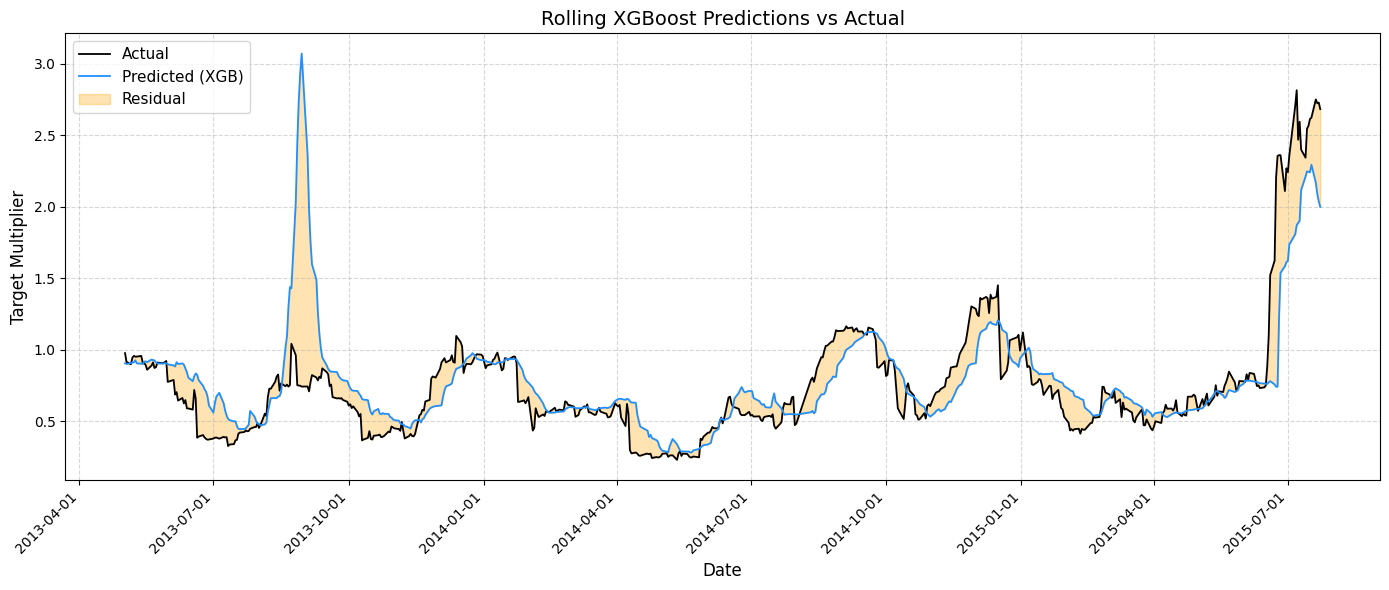

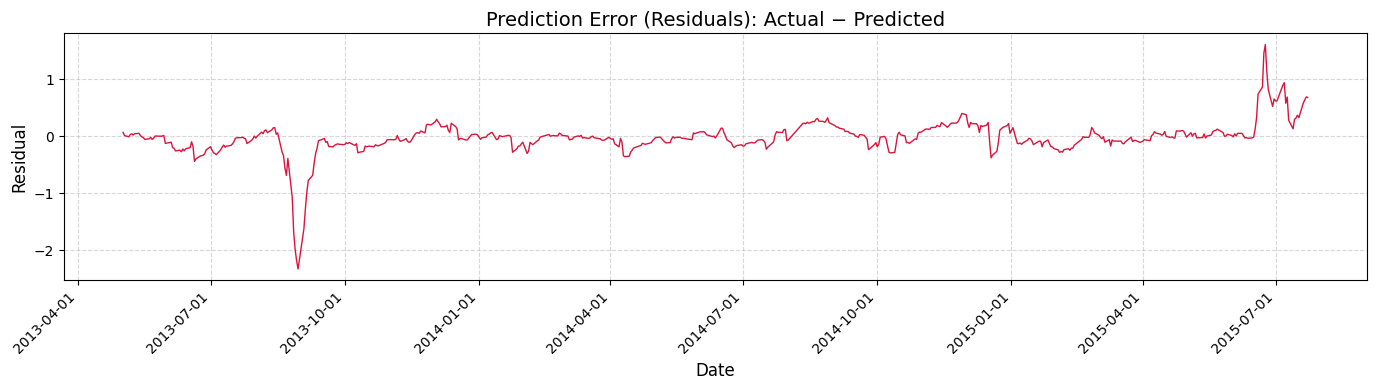

In [67]:
import matplotlib.dates as mdates

pred_df_spy_var = pred_df_spy_var_pca.copy()
print(pred_df_spy_var.head())
#   Smooth predictions by exponential moving average
pred_df_spy_var["Predicted"] = pred_df_spy_var["Predicted"].ewm(span=5, adjust=False).mean()
# Check date of har_pred
# Index spy by Date

# Merge by date column
pred_df_spy_var = pred_df_spy_var.merge(
    spy[["HAR_Pred"]],
    left_index=True,
    right_index=True,
    how="left"
)



# Compute metrics
print(pred_df_spy_var.head())
mse = mean_squared_error(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
mape = np.mean(np.abs((pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]) / pred_df_spy_var["Actual"])) * 100

r2 = r2_score(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
print(f"MSE: {mse:.6f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")


plt.figure(figsize=(14, 6))
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Actual"], label="Actual", color="black", linewidth=1.3)
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Predicted"], label="Predicted (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_spy_var.index,
    pred_df_spy_var["Actual"],
    pred_df_spy_var["Predicted"],
    color="orange",
    alpha=0.3,
    label="Residual"
)

plt.title("Rolling XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Target Multiplier", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(14, 4))
residuals = pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]
plt.plot(pred_df_spy_var.index, residuals, color="crimson", linewidth=1)
plt.title("Prediction Error (Residuals): Actual − Predicted", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()